## Тестовое задание для стажеров в команду Data Science IDP
Задание — написать решение по извлечению сущностей из документов (новостных текстов). Выполните задание в Jupyter Notebook. Ожидаемый результат: ipynb-файл с решением и всеми выводами ячеек, csv-файл с предсказаниями модели залитый в репозиторий на github.


### 1. Выбрать существующую VLM, при выборе ориентируйтесь на:
   - кол-во и качество релевантных данных на претрейне
   - размер модели
   - простоту в дообучении
   - дополнительно можете оценить простоту последующей квантизации и инференса модели

В процессе поиска подходящей модели на просторах hugging face, мой выбор пал на `llava-hf/llava-interleave-qwen-0.5b-hf` по следующим причинам:

1. Модель обучалась на научных данных нужного мне формата.
2. Размер модели состовляет 864M параметров, что является оптимальным для мощностей google colab
3. Модель состоит из трёх основных блоков: vision_model для обработки изображения,multi_modal_projector для отображения вывода из слоя vision_model в следующий слой language_model, который преобразует входы с multi_modal_projector и запроса клиента. Для до обучения всего механизма будет достаточно до обучить только последний слой language_model.
4. Тип данных модели - Tensor type BF16, а также модель поддерживает квантизацию.

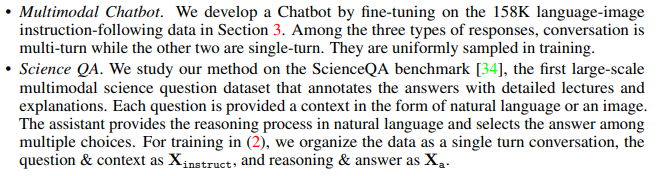

In [1]:
!pip install dataset
!pip install trl
!pip install peft

In [2]:
from transformers import BitsAndBytesConfig, LlavaForConditionalGeneration, AutoProcessor
from datasets import load_dataset
import torch

In [3]:
MAX_LENGTH = 256
MODEL_ID = "llava-hf/llava-interleave-qwen-0.5b-hf"
processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16
    ).to(0)

### 2. Выберите датасет из huggingface
(или kaggle, нужно чтобы у него было описание, при желании можете собрать самостоятельно) для задачи chart question answering.

На hugging face не смог найти ничего подходящего лучше для обучения под задачу chrart QA, чем датасет `Peppertuna/ChartQADatasetV2` (удобный формат данных и немаленькое количество).


In [5]:
dataset = load_dataset('Peppertuna/ChartQADatasetV2')

### 3. Выберите метрику для вашей задачи и объясните ее выбор. Измерьте качество модели до и после дообучения. Сделайте выводы.

В качестве метрики взял процент точных вхождений правильных ответов в предсказания.
Замерим качество модел на тестовых данных до её обучения.

In [6]:
from tqdm import tqdm
from IPython.display import clear_output

predictions = []
answers = []
for indx, row in tqdm(enumerate(dataset['test'])):
    answers.append(row['label'])
    conversation = [
        {

          "role": "user",
          "content": [
              {"type": "text", "text": row['query']},
              {"type": "image"},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

    raw_image = row['image'].convert("RGB")
    inputs = processor(images=raw_image, text=prompt, return_tensors='pt').to(0, torch.float16)

    output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
    output = processor.decode(output[0][2:], skip_special_tokens=True)
    predictions.append(output.split('\n')[-1])
    clear_output(wait=True)
    if indx == 200:
        break

200it [02:11,  1.52it/s]


In [7]:
result = 0
for i in range(len(predictions)):
    if answers[i] in predictions[i]:
        result +=1
result /= len(predictions)
print(f'Метрика до обучения: {result*100:.4} %')

Метрика до обучения: 18.91 %


Подгодовка данных в нужный для модели формат чата.

In [8]:
def peprocess(example):
  conversation = [
      {

        "role": "user",
        "content": [
            {"type": "text", "text": example['query']},
            {"type": "image"},
          ],
      },
      {

        "role": "gpt",
        "content": [
            {"type": "text", "text": example['label']},
          ],
      },
  ]
  example['conversation'] = processor.apply_chat_template(conversation, add_generation_prompt=True)
  return example

In [9]:
work_dataset = dataset.map(peprocess)

In [10]:
work_dataset = work_dataset.remove_columns(['imgname', 'table', 'query', 'query_token', 'label'])

### 4. Вам нужно будет до обучить модель на этих данных. Помните, что есть разные стратегии дообучения.

Для ускорения и упрощения процесса обучения будет использоваться LoRA из библиотеки PEFT.(сильной потери качества она не даст)

In [11]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

def find_all_linear_names(model): # заморозка параметров
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


lora_config = LoraConfig(
    lora_alpha=256,
    lora_dropout=0.05,
    r=128,
    target_modules=find_all_linear_names(model),
    init_lora_weights="pissa",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)

Параметры для конфигурации были взяты из git LLava.
https://github.com/haotian-liu/LLaVA/blob/main/scripts/v1_5/finetune_task_lora.sh

In [12]:
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer

sft_config = SFTConfig(
    dataset_text_field="conversation",
    num_train_epochs=1,
    max_seq_length=70,
    learning_rate=2e-8,
    lr_scheduler_type='cosine',
    output_dir="/output",
)
trainer = SFTTrainer(
    model,
    train_dataset=work_dataset['train'],
    eval_dataset=work_dataset['test'],
    args=sft_config,
)
trainer.train()

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

Step,Training Loss
500,5.453200
1000,4.590600
1500,4.216600
2000,4.054400
2500,3.971000


TrainOutput(global_step=2613, training_loss=4.4374355428573775, metrics={'train_runtime': 718.8431, 'train_samples_per_second': 29.076, 'train_steps_per_second': 3.635, 'total_flos': 4379175967962240.0, 'train_loss': 4.4374355428573775, 'epoch': 1.0})

In [13]:
trainer.save_model(sft_config.output_dir)

In [14]:
from tqdm import tqdm
from IPython.display import clear_output

model.eval()
tune_predictions = []
for indx, row in tqdm(enumerate(dataset['test'])):
    conversation = [
        {

          "role": "user",
          "content": [
              {"type": "text", "text": row['query']},
              {"type": "image"},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

    raw_image = row['image'].convert("RGB")
    inputs = processor(images=raw_image, text=prompt, return_tensors='pt').to(0, torch.float16)

    output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
    output = processor.decode(output[0][2:], skip_special_tokens=True)
    tune_predictions.append(output.split('\n')[-1])
    clear_output(wait=True)
    if indx == 200:
        break

200it [02:20,  1.42it/s]


In [15]:
tune_result = 0
for i in range(len(tune_predictions)):
    if answers[i] in tune_predictions[i]:
        tune_result +=1
tune_result /= len(tune_predictions)
print(f'Метрика после обучения: {tune_result*100:.2f} %')

Метрика после обучения: 21.89 %


In [16]:
print(f'Прогресс обучения: {((tune_result - result) * 100):.2f} %')

Прогресс обучения: 2.99 %


In [25]:
from huggingface_hub import notebook_login

notebook_login()

In [26]:
trainer.push_to_hub()

events.out.tfevents.1729087624.84525e397a41.1594.0:   0%|          | 0.00/8.31k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/334M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1729089426.84525e397a41.9634.0:   0%|          | 0.00/7.25k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/antrisole/output/commit/b07398b4628612a64162c10c1a2db694b7da1b3b', commit_message='End of training', commit_description='', oid='b07398b4628612a64162c10c1a2db694b7da1b3b', pr_url=None, pr_revision=None, pr_num=None)

In [32]:
import pandas as pd

df = pd.DataFrame({
    'query': dataset['test'][:201]['query'],
    'image': dataset['test'][:201]['imgname'],
    'predict': tune_predictions
})
df.head()

,query,image,predict
0,How many stores did Saint Laurent operate in W...,multi_col_803.png,51
1,In what year did online sales make up 6.8 perc...,multi_col_20436.png,2013
2,What percentage of the retail sales of jewelry...,multi_col_20436.png,6.2
3,What is the predicted increase in online sales...,multi_col_20436.png,11.2
4,How many companies were in Hungary's insurance...,multi_col_20505.png,32


In [33]:
df.to_csv('data.csv', index=False)